Install a few more packages required to run this notebook

In [1]:
%%capture
!pip install tqdm seaborn mols2grid sklearn pingouin

In [2]:
import useful_rdkit_utils as uru
import pandas as pd
from rdkit import Chem
from tqdm.auto import tqdm
import seaborn as sns
import mols2grid
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import numpy as np
import pingouin

### 0. Preliminary Setup

In [3]:
tqdm.pandas()

In [4]:
mol_buff = """Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1 32842
CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+] 674933
Cl.N=C(N)N 674679
CC1=CC(=O)c2ccccc2C1=O 19344
Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n(C)c1=O.NCCN 794445
C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C 328400
C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC[C@@H]2[C@H](C)/C=C/[C@H](C)C(C)C 430124
Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[O-].O.O.O.O.O.O.[Na+].[Na+].[Na+].[Na+] 2197599
CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1 860
Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1 2131"""
mol_buff_list = [x.split() for x in mol_buff.split("\n")]
mol_df = pd.DataFrame(mol_buff_list,columns=["SMILES","Name"])

In [5]:
mol_df

,SMILES,Name
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,32842
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+],674933
2,Cl.N=C(N)N,674679
3,CC1=CC(=O)c2ccccc2C1=O,19344
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,794445
5,C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[...,328400
6,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC...,430124
7,Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[...,2197599
8,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,860
9,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,2131


## 1. Molecular Geometry

In [6]:
mol_df['mol'] = mol_df.SMILES.apply(Chem.MolFromSmiles)

### 1.1 Generate a 3D structure

In [7]:
mol_df.mol = mol_df.mol.apply(uru.gen_3d)

### 1.2 View a 3D structure

In [8]:
uru.MolTo3DView(mol_df.mol[0])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 1.3 Find the geometric center of a molecule

In [9]:
mol_df[['x','y','z']] = mol_df.mol.apply(uru.get_center).to_list()

In [10]:
mol_df.head()

,SMILES,Name,mol,x,y,z
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,32842,<rdkit.Chem.rdchem.Mol object at 0x36c02e6c0>,0.183724,0.407990,-0.249123
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+],674933,<rdkit.Chem.rdchem.Mol object at 0x36e151690>,-0.582119,0.395525,-0.042205
2,Cl.N=C(N)N,674679,<rdkit.Chem.rdchem.Mol object at 0x36e151f50>,0.202839,-0.175674,0.002378
3,CC1=CC(=O)c2ccccc2C1=O,19344,<rdkit.Chem.rdchem.Mol object at 0x36e1520a0>,0.142537,0.113488,0.011663
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,794445,<rdkit.Chem.rdchem.Mol object at 0x36e152570>,-0.017820,-0.177234,-0.032254


### 1.4 Calculate and plot the first two shape moments for a set of molecules

Read a SMILES file with drugs from ChEMBL into a Pandas dataframe

In [21]:
drug_df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/datafiles/main/chembl_drugs.smi",
                     names=["SMILES","Name"],sep=" ")

Add a molecule column to the dataframe

In [22]:
drug_df['mol'] = drug_df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/1203 [00:00<?, ?it/s]

Strip salts, etc. by extracting the largest fragment from each molecule

In [23]:
drug_df.mol = drug_df.mol.progress_apply(uru.get_largest_fragment)

  0%|          | 0/1203 [00:00<?, ?it/s]

We want to limit this analysis to molecules with molecular weight < 500 so well calculate rule of 5 properties

In [24]:
ro5_calc = uru.Ro5Calculator()
drug_df[ro5_calc.names] = drug_df.mol.progress_apply(ro5_calc.calc_mol).to_list()

  0%|          | 0/1203 [00:00<?, ?it/s]

Remove molecules with MW > 500

In [25]:
drug_df = drug_df.query("MolWt <= 500")

Remove molecules with non-standard atom types

In [26]:
weird_atom_smarts = "[!#1;!C;!O;!N;!S;!P;!F;!Cl;!Br;!I;!c;!o;!n;!s;!p;!Na;!K;!Mg;!Ca;!Li]"
weird_atom_pat = Chem.MolFromSmarts(weird_atom_smarts)
drug_df['odd'] = [x.HasSubstructMatch(weird_atom_pat) for x in drug_df.mol]

In [27]:
drug_df = drug_df.query("not odd")

Add a 3D structure to the molecules

In [30]:
drug_df.mol = drug_df.mol.progress_apply(uru.gen_3d)

  0%|          | 0/1042 [00:00<?, ?it/s]

[09:02:04] UFFTYPER: Unrecognized charge state for atom: 5
[09:02:08] UFFTYPER: Unrecognized charge state for atom: 21
[09:02:11] UFFTYPER: Unrecognized charge state for atom: 20
[09:02:18] UFFTYPER: Unrecognized charge state for atom: 8
[09:02:21] UFFTYPER: Unrecognized charge state for atom: 14
[09:02:28] UFFTYPER: Unrecognized charge state for atom: 4
[09:02:30] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[09:02:30] UFFTYPER: Unrecognized charge state for atom: 0
[09:02:30] UFFTYPER: Unrecognized charge state for atom: 12
[09:02:30] UFFTYPER: Unrecognized charge state for atom: 8
[09:02:30] UFFTYPER: Unrecognized charge state for atom: 8
[09:02:30] UFFTYPER: Unrecognized charge state for atom: 8
[09:02:33] UFFTYPER: Unrecognized charge state for atom: 4
[09:02:35] UFFTYPER: Unrecognized charge state for atom: 14
[09:02:41] UFFTYPER: Unrecognized charge state for atom: 8
[09:02:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1


Remove molecules without a 3D structure

In [31]:
drug_df.dropna(subset=['mol'],inplace=True)

Define the pricipal moments

In [32]:
drug_df[['NPR1','NPR2']] = drug_df.mol.apply(uru.get_shape_moments).to_list()

Plot the principal moments

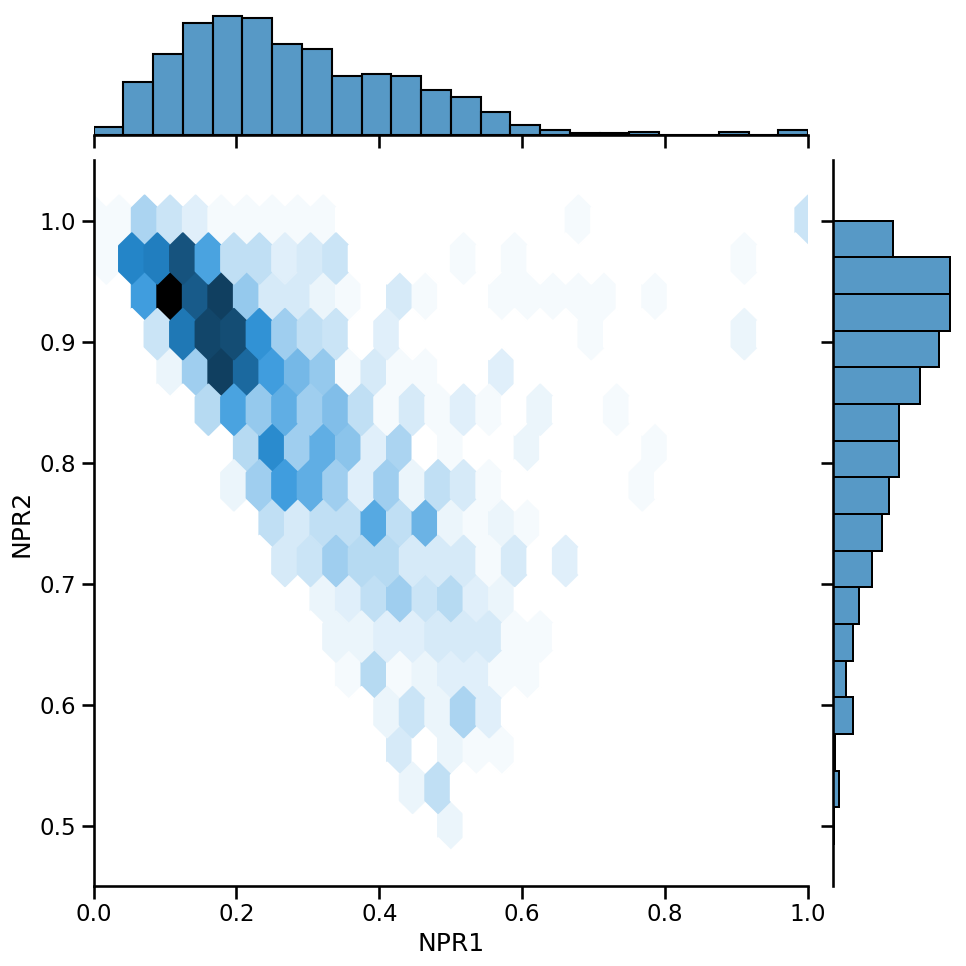

In [33]:
sns.set_context('talk')
ax = sns.jointplot(x='NPR1', y='NPR2', data=drug_df, kind="hex",height=10)
ax.ax_marg_x.set_xlim(0, 1)
ax.ax_marg_y.set_ylim(0.45, 1.05);

## 2. Clustering

### 2.1 Generating molecular fingerprints

In [34]:
drug_df['fp'] = drug_df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/1041 [00:00<?, ?it/s]

### 2.2 Clustering using the Taylor-Butina algorithm

In [35]:
drug_df['cluster'] = uru.taylor_butina_clustering(drug_df.fp.values)

In [36]:
drug_df.cluster.value_counts()

cluster
0      24
1      22
2      19
3      18
5      16
       ..
385     1
386     1
387     1
388     1
216     1
Name: count, Length: 493, dtype: int64

In [37]:
mols2grid.display(drug_df.query('cluster==0'),subset=["img"])

MolGridWidget()

## 3. Building a machine learning model
We'll build two machine learning models, one using RDKit Morgan fingerprints as descriptors and another using Morgan fingerprints + descriptors.  After that we'll compare the models. 

### 3.1 Building the models
Read a dataset with SMILES, Name, and pIC50

In [38]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/yamc/main/data/A2a.smi",
                 sep=" ",
                 names=["SMILES","Name","pIC50"])

Instantiate a Smi2Fp object

In [39]:
smi2fp = uru.Smi2Fp()

Add a fingerprint column as a numpy array

In [40]:
df['fp'] = df.SMILES.apply(smi2fp.get_np)

Calculate RDKit properties

In [43]:
rdkit_props = uru.RDKitProperties()
df['desc'] = df.SMILES.apply(rdkit_props.calc_smiles)
df['fp_plus_desc'] = [np.append(a,b) for a,b in df[['fp','desc']].values]

Perform 10 cycles of cross validation and save the R^2 values for each cycle. 

In [44]:
r2_list = []
for i in tqdm(range(0,10)):
    train, test = train_test_split(df)
    train_X_fp = np.stack(train.fp)
    train_X_fp_plus_desc = np.stack(train.fp_plus_desc)
    train_y = train.pIC50.values
    test_X_fp = np.stack(test.fp)
    test_X_fp_plus_desc = np.stack(test.fp_plus_desc)
    test_y = test.pIC50.values
    model_fp = ExtraTreesRegressor()
    model_fp_plus_desc = ExtraTreesRegressor()
    model_fp.fit(train_X_fp, train_y)
    model_fp_plus_desc.fit(train_X_fp_plus_desc, train_y)
    pred_fp_r2 = r2_score(test_y,model_fp.predict(test_X_fp))
    pred_fp_plus_desc_r2 = r2_score(test_y,model_fp_plus_desc.predict(test_X_fp_plus_desc))
    r2_list.append([i,pred_fp_r2, pred_fp_plus_desc_r2])
r2_df = pd.DataFrame(r2_list,columns=["cycle","fp","fp_plus_desc"])

  0%|          | 0/10 [00:00<?, ?it/s]

### 3.2 Comparing the models
Transform the data for plotting

In [45]:
melt_df = r2_df.melt(id_vars="cycle")
melt_df.columns = ["cycle","method","R2"]
melt_df

,cycle,method,R2
0,0,fp,0.487695
1,1,fp,0.303563
2,2,fp,-0.037993
3,3,fp,0.705726
4,4,fp,0.138067
5,5,fp,0.428576
6,6,fp,0.432310
7,7,fp,0.307631
8,8,fp,0.641787
9,9,fp,0.536512


I to use the paired plots from the pigouin Python package as an inutitive means of comparing methods. 

/Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


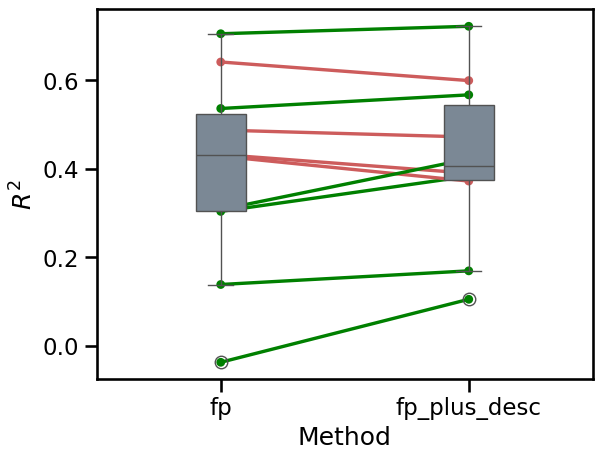

In [46]:
ax = pingouin.plot_paired(data=melt_df,dv="R2",within="method",subject="cycle");
ax.set_xlabel("Method")
ax.set_ylabel("$R^2$");

In order to have a more robust comparison we'll calculatee the effect size.  Since we have a small sample size we'll use the Hedges method in place of Cohen's. As reminder, here's a table summarizing the meaning of the effect size. 
* Small Effect Size: d=0.20
* Medium Effect Size: d=0.50
* Large Effect Size: d=0.80

In [47]:
eff_size = pingouin.compute_effsize(r2_df.fp,r2_df.fp_plus_desc,eftype="cohen")
eff_size.round(2)

-0.13

We can also use the equation below to translate Cohen's d into a probability between 0 and 1. 


As we can see the effect size is small and probability of one method being better than the other is low.  Of course, in practice, we would do this comparison over many more datasets. 

In [48]:
(0.25 * abs(eff_size) + 0.5).round(2)

0.53

## 4. Ring features and structure display

In [49]:
spiro_mol = Chem.MolFromSmiles("C1CCC2(C1)Cc1ccccc1C2")

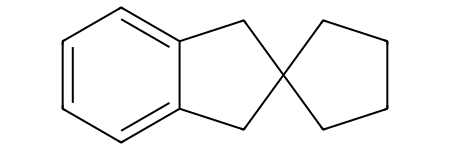

In [50]:
spiro_mol

### 4.1 Labeling atoms
Label atoms by index

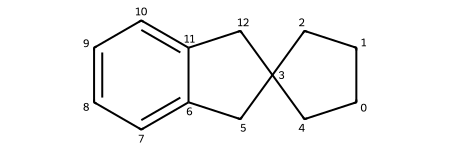

In [51]:
uru.label_atoms(spiro_mol,[x.GetIdx() for x in spiro_mol.GetAtoms()])

### 4.2 Identify spiro atoms

In [52]:
spiro_atoms = uru.get_spiro_atoms(spiro_mol)
spiro_atoms

[3]

### 4.3 Tagging spiro atoms

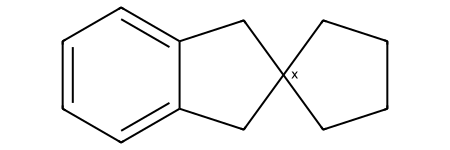

In [53]:
uru.tag_atoms(spiro_mol,spiro_atoms)

### 4.4 Identifying the largest ring

In [54]:
uru.max_ring_size(spiro_mol)

6